In [1]:
import os


import jax


import scipy
import numpy as np
import sys
sys.path.append("/home/jgould/Documents/AdaptiveLatents/scripts/")
from main import main
from proSVD import proSVD


In [5]:
print(repr(jax.numpy.square(3)))
print(repr(jax.numpy.square(3).devices()))

Array(9, dtype=int64, weak_type=True)
{cuda(id=0)}


In [2]:
def formatXY(X, Y):
    ## Format X and Y from paper Data

    ## Isolate Training Data
    k = np.shape(X)[1]
    y = 96
    XTrain = np.ones([np.shape(X)[0]+1,k])
    YTrain = np.zeros([y,k])

    # Shift Velocity vals up a position
    X[2:4, 1:] = X[2:4, :-1]
    XTrain[0:4, :] = X[:,:]
    
    # Set low velocitys equal to 0
    XTrain[2:4, :][abs(XTrain[2:4, :]) < .00001] = 0

    if np.shape(Y)[0] > 96:
        i = range(0, len(Y), 4)
        YTrain[:,:] = Y[i, :] / 100
    else:
        YTrain = Y / 100
    
    return XTrain, YTrain

In [3]:
def loadFile(fileType, m = 0, n = 0):      

    fileName = '/home/jgould/Documents/Bubblewrap/generated/datasets/from_rio/Data/MonkeyReach/Monkey' + fileType + '.mat'
    data = scipy.io.loadmat(fileName)

    Output = np.transpose(data.get('y')) #Kinematic Data
    Input = np.transpose(data.get('X')) # Neural Data
    targs = np.transpose(data.get('targ')) # Target locations
    targsize = data.get('targsize')[0]
    targsize = targsize[0]
    trials = np.transpose(data.get('trials'))[0]
    
    if n == 0:
        n = np.shape(Output)[1]
        
    if m > n:
        print("Error, start index must be lower than end index")

    # trialInfo = self.getTrialInfo(trials[m:n], targs[:, m:n])

    Output, Input = formatXY(Output[:, m:n], Input[:, m:n])
    
    X = Output
    Y = Input
    
    return X, Y
    # return trialInfo, targsize


In [4]:
def reducePSVD(X, ncomp):
    pro = proSVD(k=ncomp)
    pro.initialize(X[:100, :].T)
    output = []
    for i in range(100, np.shape(X)[0]):
        obs = X[i:i + 1, :]
        if np.any(np.isnan(obs)):
            output.append(np.zeros(ncomp) * np.nan)
            continue
        pro.preupdate()
        pro.updateSVD(obs.T)
        pro.postupdate()
        obs = obs @ pro.Q
        output.append(obs)
        # reduced = DataSet(fullData.X[:, 100:], np.array(output).reshape((-1, ncomp)).T, fullData)
    return np.array(output).reshape((-1, ncomp)).T

In [5]:
import adaptive_latents.plotting_functions as bpf
from adaptive_latents.regressions import NearestNeighborRegressor
from proSVD import proSVD
from adaptive_latents import NumpyTimedDataSource, Bubblewrap, default_rwd_parameters, AnimationManager, BWRun, SymmetricNoisyRegressor

In [6]:
from jax.lib import xla_bridge
xla_bridge.get_backend().platform


'cpu'

In [7]:


def main(Y, X, steps_to_run=None, nBubbles=200, svd = False):
    # if svd == True:
    #     prosvd_init = nDims
    #     psvd = proSVD(nDims)
    #     psvd.initialize(Y[:, :prosvd_init].T)
    # print(psvd)
    # gg @ psvd.Q
    obs = (Y).T
    beh = (X).T
    in_ds = NumpyTimedDataSource(obs, None, time_offsets=(1,))
    out_ds = NumpyTimedDataSource(beh, None, time_offsets=(1,))
    # define the adaptive_latents object
    bw = Bubblewrap(dim=in_ds.output_shape,  **dict(default_rwd_parameters, num = nBubbles, B_thresh=-15, copy_row_on_teleport=False))
    # bw.N = 10
    # define the (optional) method to regress the HMM state from `bw.alpha`
    reg = SymmetricNoisyRegressor(input_d=bw.N, output_d=out_ds.output_shape)
    # reg = NearestNeighborRegressor(input_d=bw.N, output_d=1, maxlen=600)
 
    # am = CustomAnimation()
    # define the object to coordinate all the other objects
    br = BWRun(bw=bw, in_ds=in_ds, out_ds=out_ds, behavior_regressor=reg, show_tqdm=True)
    # run and save the outp
    br.run(limit=steps_to_run, save = True)
    return br

100%|███████████████████████████████████▉| 47886/47887 [03:15<00:00, 245.02it/s]
/home/jgould/Documents/AdaptiveLatents/adaptive_latents/plotting_functions.py:480: UserWarning: check these timepoints actually line up, I'm just clipping here
  warnings.warn("check these timepoints actually line up, I'm just clipping here")


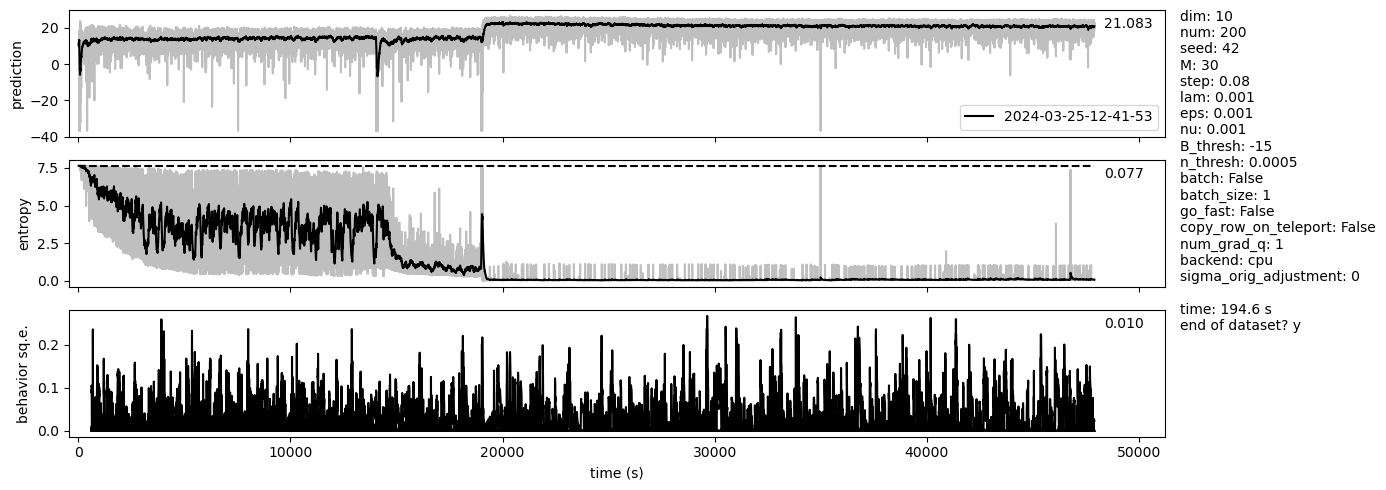

In [8]:
X1, Y1 = loadFile('N_MC')
X2, Y2 = loadFile('W_MC')

X = np.hstack([X1, X2])
Y = np.hstack([Y1, Y2])

brs = []
decomp = reducePSVD(Y.T, 10)

X = X[:,-decomp.shape[1]:]
br = main(decomp, X, nBubbles=200)
brs.append(br) 
bpf.compare_metrics([br], 1)

100%|███████████████████████████████████▉| 47886/47887 [06:41<00:00, 119.14it/s]
/home/jgould/Documents/AdaptiveLatents/adaptive_latents/plotting_functions.py:480: UserWarning: check these timepoints actually line up, I'm just clipping here
  warnings.warn("check these timepoints actually line up, I'm just clipping here")


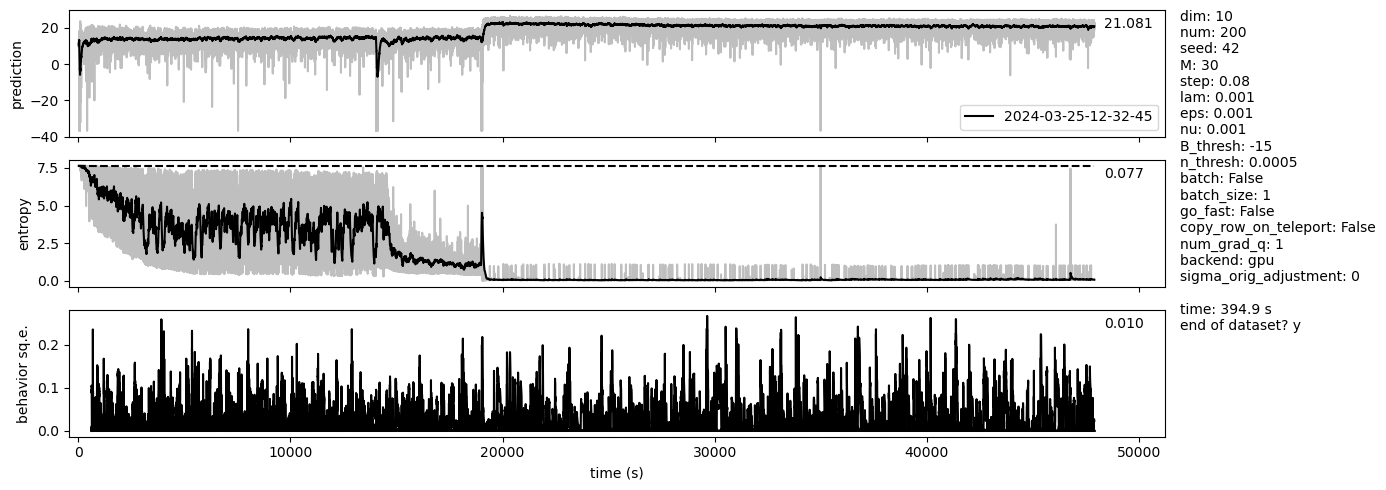

In [8]:
X1, Y1 = loadFile('N_MC')
X2, Y2 = loadFile('W_MC')

X = np.hstack([X1, X2])
Y = np.hstack([Y1, Y2])

brs = []
decomp = reducePSVD(Y.T, 10)

X = X[:,-decomp.shape[1]:]
br = main(decomp, X, nBubbles=200)
brs.append(br) 
bpf.compare_metrics([br], 1)